In [1]:
# import necessary libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

# set random seed
np.random.seed(42)

# load CIFAR-10 data
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()

# check data size
assert X_train.shape == (50000, 32, 32, 3)
assert X_test.shape == (10000, 32, 32, 3)
assert y_train.shape == (50000, 1)
assert y_test.shape == (10000, 1)

# combine data first - we will generate test set later.
X = np.concatenate([X_train,X_test],axis=0)
y = np.concatenate([y_train,y_test],axis=0)
y = np.squeeze(y)

assert X.shape == (60000, 32, 32, 3)
assert y.shape == (60000,)

# check number of data in each class
unique, counts = np.unique(y,return_counts=True)
np.asarray([unique,counts]).T

170498071/170498071 [==============================] - 7s 0us/step


array([[   0, 6000],
       [   1, 6000],
       [   2, 6000],
       [   3, 6000],
       [   4, 6000],
       [   5, 6000],
       [   6, 6000],
       [   7, 6000],
       [   8, 6000],
       [   9, 6000]])

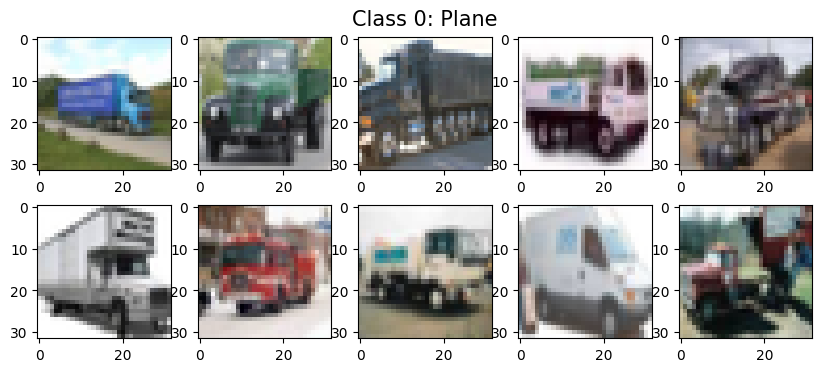

In [2]:
# Plot Class N (0-9)

TARGET = 9 # Class index here
NUM_ARRAYS = 10

arrays = X[np.where(y==TARGET)]
random_arrays_indices = np.random.choice(len(arrays),NUM_ARRAYS)
random_arrays = arrays[random_arrays_indices]

fig = plt.figure(figsize=[NUM_ARRAYS,4])
plt.title('Class 0: Plane',fontsize = 15)
plt.axis('off')

for index in range(NUM_ARRAYS):
     fig.add_subplot(2, int(NUM_ARRAYS/2), index+1)
     plt.imshow(random_arrays[index])

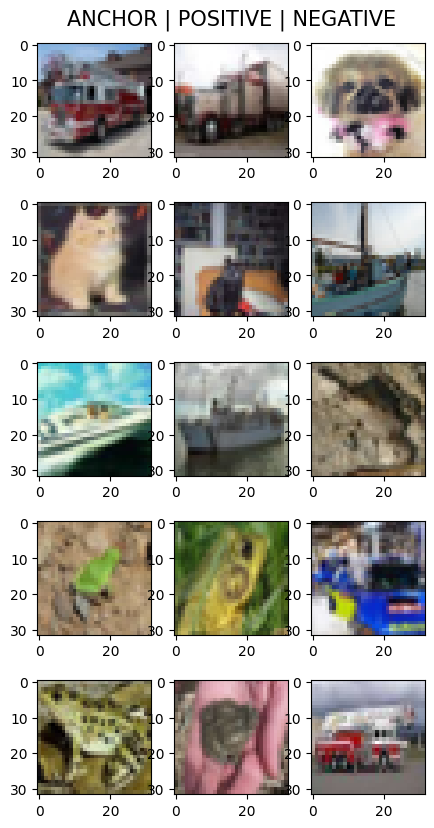

In [3]:
# initialize triplets array
triplets = np.empty((0,3,32,32,3),dtype=np.uint8)

# get triplets for each class
for target in range(10):

    locals()['arrays_'+str(target)] = X[np.where(y==target)].reshape(3000,2,32,32,3)
    locals()['arrays_not_'+str(target)] = X[np.where(y!=target)]

    random_indices = np.random.choice(len(locals()['arrays_not_'+str(target)]),3000)
    locals()['arrays_not_'+str(target)] = locals()['arrays_not_'+str(target)][random_indices]

    locals()['arrays_'+str(target)] = np.concatenate(
        [
            locals()['arrays_'+str(target)],
            locals()['arrays_not_'+str(target)].reshape(3000,1,32,32,3)
        ],
        axis = 1
    )

    triplets = np.concatenate([triplets,locals()['arrays_'+str(target)]],axis=0)

# check triplets size
assert triplets.shape == (30000,3,32,32,3)

# plot triplets array to visualize
TEST_SIZE = 5
random_indices = np.random.choice(len(triplets),TEST_SIZE)

fig = plt.figure(figsize=[5,2*TEST_SIZE])
plt.title('ANCHOR | POSITIVE | NEGATIVE',fontsize = 15)
plt.axis('off')

for row,i in enumerate(range(0,TEST_SIZE*3,3)):
    for j in range(1,4):
        fig.add_subplot(TEST_SIZE, 3, i+j)
        random_index = random_indices[row]
        plt.imshow(triplets[random_index,j-1])

# save triplet array
np.save('triplets_array.npy',triplets)

##### Preparaing the model training

In [4]:
# Import all libraries

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Input, optimizers, Model
from tensorflow.keras.layers import Layer, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split

from scipy import spatial

In [5]:
triplets = np.load('triplets_array.npy')

triplets = triplets/255 #normalize by 255
labels = np.ones(len(triplets)) #create a fixed label

assert triplets.shape == (30000,3,32,32,3)

In [6]:
# Split data into our train and test set

X_train, X_test, y_train, y_test = train_test_split(
    triplets,
    labels,
    test_size=0.05,
    random_state=42
)

In [7]:
# Load pretrained model for transfer learning

pretrained_model = MobileNetV2(
    weights='imagenet', 
    include_top=False, 
    input_shape=(32,32,3)
)

for layer in pretrained_model.layers:
    layer.trainable = True

9406464/9406464 [==============================] - 1s 0us/step


In [8]:
# Initialize functions for Lambda Layer

def cosine_distance(x,y):
    x = K.l2_normalize(x, axis=-1)
    y = K.l2_normalize(y, axis=-1)
    distance = 1 - K.batch_dot(x, y, axes=-1)
    return distance

def triplet_loss(templates, margin=0.4):
    
    anchor,positive,negative = templates
    
    positive_distance = cosine_distance(anchor,positive)
    negative_distance = cosine_distance(anchor,negative)
    
    basic_loss = positive_distance-negative_distance+margin
    loss = K.maximum(basic_loss,0.0)
    
    return loss

In [9]:
# Adopting the TensorFlow Functional API

anchor = Input(shape=(32, 32,3), name='anchor_input')
A = pretrained_model(anchor)

positive = Input(shape=(32, 32,3), name='positive_input')
P = pretrained_model(positive)

negative = Input(shape=(32, 32,3), name='negative_input')
N = pretrained_model(negative)

loss = Lambda(triplet_loss)([A, P, N])

model = Model(inputs=[anchor,positive,negative],outputs=loss)

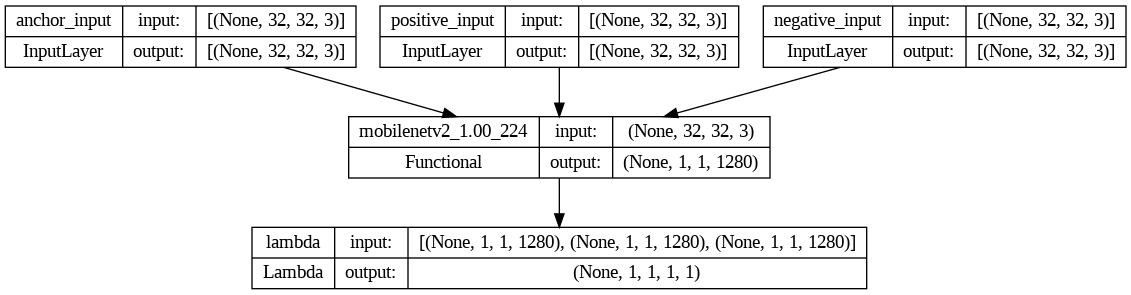

In [10]:
# Create a custom loss function since there are no ground truths label

def identity_loss(y_true, y_pred):
    return K.mean(y_pred)

model.compile(loss=identity_loss, optimizer=Adam(learning_rate=1e-4))

callbacks=[EarlyStopping(
    patience=2, 
    verbose=1, 
    restore_best_weights=True,
    monitor='val_loss'
    )]

# view model
plot_model(model, show_shapes=True, show_layer_names=True, to_file='siamese_triplet_loss_model.png')

In [11]:
# Start training - y_train and y_test are dummy

model.fit(
    [X_train[:,0],X_train[:,1],X_train[:,2]],
    y_train,
    epochs=50, 
    batch_size=64,
    validation_data=([X_test[:,0],X_test[:,1],X_test[:,2]],y_test),
    callbacks=callbacks
)


Epoch 1/50
446/446 [==============================] - 87s 89ms/step - loss: 0.3377 - val_loss: 0.3634
Epoch 2/50
446/446 [==============================] - 36s 80ms/step - loss: 0.2345 - val_loss: 0.2360
Epoch 3/50
446/446 [==============================] - 36s 80ms/step - loss: 0.1965 - val_loss: 0.2161
Epoch 4/50
446/446 [==============================] - 36s 81ms/step - loss: 0.1710 - val_loss: 0.1878
Epoch 5/50
446/446 [==============================] - 36s 80ms/step - loss: 0.1522 - val_loss: 0.1767
Epoch 6/50
446/446 [==============================] - 36s 80ms/step - loss: 0.1405 - val_loss: 0.1627
Epoch 7/50
446/446 [==============================] - 36s 80ms/step - loss: 0.1228 - val_loss: 0.1581
Epoch 8/50
446/446 [==============================] - 36s 81ms/step - loss: 0.1130 - val_loss: 0.1517
Epoch 9/50
446/446 [==============================] - 36s 80ms/step - loss: 0.1014 - val_loss: 0.1395
Epoch 10/50
446/446 [==============================] - 36s 80ms/step - loss: 0.094

In [12]:
X_test_anchor = X_test[:,0]
X_test_positive = X_test[:,1]
X_test_negative = X_test[:,2]

# extract the CNN model for inference
siamese_model = model.layers[3]

X_test_anchor_template = np.squeeze(siamese_model.predict(X_test_anchor))
X_test_positive_template = np.squeeze(siamese_model.predict(X_test_positive))
X_test_negative_template = np.squeeze(siamese_model.predict(X_test_negative))

y_test_targets = np.concatenate([np.ones((len(X_test),)),np.zeros((len(X_test),))])

47/47 [==============================] - 0s 5ms/step


In [13]:
# Get predictions in angular similarity scores

def angular_similarity(template1,template2):
    
    score = np.float32(1-np.arccos(1-spatial.distance.cosine(template1,template2))/np.pi)
    
    return score

y_predict_targets = []

for index in range(len(X_test)):
    similarity = angular_similarity(X_test_anchor_template[index],X_test_positive_template[index])
    y_predict_targets.append(similarity)
    
for index in range(len(X_test)):
    similarity = angular_similarity(X_test_anchor_template[index],X_test_negative_template[index])
    y_predict_targets.append(similarity)

Text(0.5, 1.0, 'Receiver Operating Characteristic (ROC) Curve')

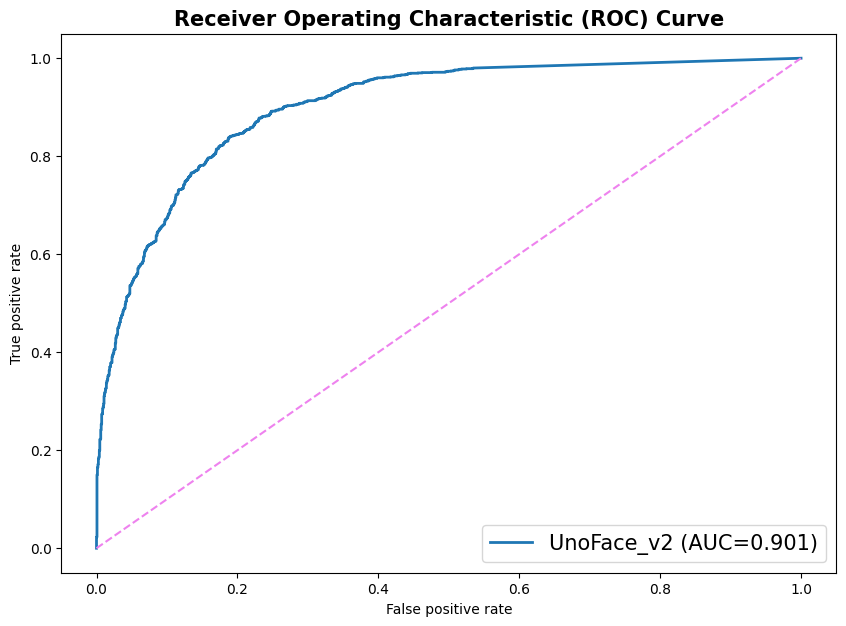

In [14]:
# Get prediction results with ROC Curve and AUC scores

fpr, tpr, thresholds = roc_curve(y_test_targets, y_predict_targets)

fig = plt.figure(figsize=[10,7])
plt.plot(fpr, tpr,lw=2,label='UnoFace_v2 (AUC={:.3f})'.format(roc_auc_score(y_test_targets, y_predict_targets)))
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.legend(loc="lower right",fontsize=15)

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Receiver Operating Characteristic (ROC) Curve',weight='bold',fontsize=15)

In [15]:
# Getting Test Pairs and their Corresponding Predictions

positive_comparisons = X_test[:,[0,1]]
negative_comparisons = X_test[:,[0,2]]

positive_predict_targets = np.array(y_predict_targets)[:1500]
negative_predict_targets = np.array(y_predict_targets)[1500:]

assert positive_comparisons.shape == (1500,2,32,32,3)
assert negative_comparisons.shape == (1500,2,32,32,3)

assert positive_predict_targets.shape == (1500,)
assert negative_predict_targets.shape == (1500,)

np.random.seed(21)
NUM_EXAMPLES = 5
random_index = np.random.choice(range(len(positive_comparisons)),NUM_EXAMPLES)

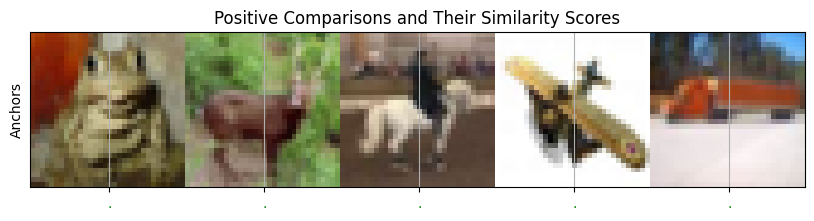

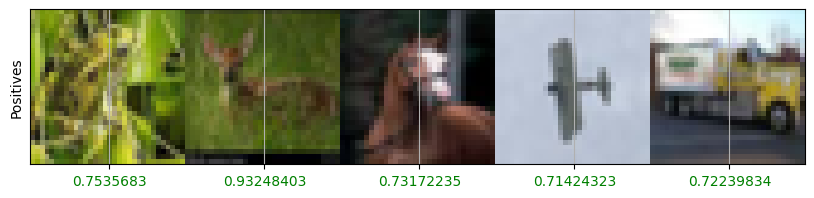

In [16]:
# Plotting Similarity Scores for Positive Comparisons 
# (Switch values and input to plot for Negative Comparisons)

plt.figure(figsize=(10,4))
plt.title('Positive Comparisons and Their Similarity Scores')
plt.ylabel('Anchors')
plt.yticks([])
plt.xticks([32*x+16 for x in range(NUM_EXAMPLES)], ['.' for x in range(NUM_EXAMPLES)])
for i,t in enumerate(plt.gca().xaxis.get_ticklabels()):
    t.set_color('green') 
plt.grid(None)
anchor = np.swapaxes(positive_comparisons[:,0][random_index],0,1)
anchor = np.reshape(anchor,[32,NUM_EXAMPLES*32,3])
plt.imshow(anchor)

plt.figure(figsize=(10,4))
plt.ylabel('Positives')
plt.yticks([])
plt.xticks([32*x+16 for x in range(NUM_EXAMPLES)], positive_predict_targets[random_index])
for i,t in enumerate(plt.gca().xaxis.get_ticklabels()):
    t.set_color('green') 
plt.grid(None)
positive = np.swapaxes(positive_comparisons[:,1][random_index],0,1)
positive = np.reshape(positive,[32,NUM_EXAMPLES*32,3])
plt.imshow(positive)